In [1]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# importing the 'Value' type
from utils import Value, MLP
from utils import PalindromeDataset, PalindromeDatasetFull

In [3]:
datasetMaker = PalindromeDataset(10)
dataset = datasetMaker.generate_dataset(512, 512)

In [4]:
len(dataset)

1024

In [5]:
def convert_to_form(dataset):
    xs = []
    ys = []
    for x, y in dataset:
        xs.append([int(k) for k in list(x)])
        ys.append(y)
    return xs, ys

In [7]:
# input dim=10, output dim=1, architecture : NN with 1 hidden layer : 4 with neurons

losslog = []
a = MLP(10, [4, 1])
weight = 1. # added weight to try and counter the class imbalance
nepochs = 751

xs, ys = convert_to_form(dataset)

for step in tqdm(range(nepochs)) : 
    # forward pass
    ypred = [a(x)[0] for x in xs]
    # loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    loss = sum(-weight*ytrue*ypred.log()-(1-ytrue)*(1-ypred).log() for ytrue, ypred in zip(ys, ypred)) # BCE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()

    if step%50==0 : tqdm.write(f'epoch {step} loss {loss.data:.4f}')
    
    # update 
    for w in a.parameters() :
        w.data -= 0.005 * w.grad # standard SGD for now

  0%|          | 0/751 [00:00<?, ?it/s]

epoch 0 loss 821.5827
epoch 50 loss 669.8101
epoch 100 loss 493.9504
epoch 150 loss 380.9004
epoch 200 loss 258.1078
epoch 250 loss 196.4732
epoch 300 loss 154.6927
epoch 350 loss 124.6852
epoch 400 loss 104.5145
epoch 450 loss 90.4343
epoch 500 loss 79.2013
epoch 550 loss 69.8971
epoch 600 loss 62.1629
epoch 650 loss 55.6880
epoch 700 loss 49.9954
epoch 750 loss 44.6822


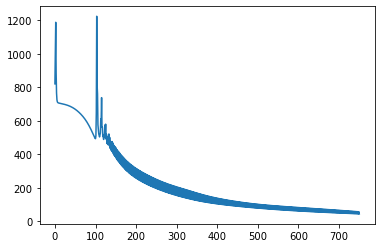

In [8]:
plt.plot(losslog)
plt.show()

In [9]:
eps = 1e-8
predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    thresh = i/10
    preds = np.array(1*(predictions > thresh))

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    # true_pos = sum(np.array(ys)==1 and preds==1)
    # true_neg = sum(np.array(ys)==0 and preds==0)
    # false_pos = sum(np.array(ys)==0 and preds==1)
    # false_neg = sum(np.array(ys)==1 and preds==0)

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)
    print(f'Threshold {thresh:.1f} accuracy {acc:.4f} f1 {f1:.4f}')

Threshold 0.1 accuracy 0.9424 f1 0.9455
Threshold 0.2 accuracy 0.9551 f1 0.9570
Threshold 0.3 accuracy 0.9600 f1 0.9615
Threshold 0.4 accuracy 0.9688 f1 0.9697
Threshold 0.5 accuracy 0.9775 f1 0.9780
Threshold 0.6 accuracy 0.9824 f1 0.9827
Threshold 0.7 accuracy 0.9883 f1 0.9884
Threshold 0.8 accuracy 0.9932 f1 0.9932
Threshold 0.9 accuracy 0.9961 f1 0.9961


In [10]:
max(predictions), min(predictions)

(0.9988894667923126, 3.0223320472428493e-05)

In [11]:
# Testing on the complete dataset to decide on what to take as the threshold for predictions


# testing on full dataset
test_datasetMaker = PalindromeDatasetFull(10)
test_dataset = test_datasetMaker.generate_dataset()

xs, ys = convert_to_form(test_dataset)

predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    preds = 1*(predictions > i/10)

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)

    print(i/10, acc, f1)

#confusion_matrix(ys, preds)

0.1 0.8125 0.24999999779296878
0.2 0.8310546875 0.27004219173423066
0.3 0.8515625 0.296296293744856
0.4 0.8681640625 0.3216080374697609
0.5 0.884765625 0.3516483487115083
0.6 0.900390625 0.3855421655160401
0.7 0.916015625 0.4266666632533334
0.8 0.9404296875 0.5119999961088001
0.9 0.9619140625 0.6213592188971628


A Threshold of 0.98 seems to do the best job at the required classification.  
We use this value for the threshold for all our analysis

In [97]:
from sklearn.metrics import confusion_matrix

THRESH = 0.99
preds = 1*(predictions > THRESH)
true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

num_correct = true_neg + true_pos
prec = true_pos / (true_pos + false_pos + eps)
recall = true_pos / (true_pos + false_neg + eps)
f1 = 2*prec*recall / (prec + recall + eps)
acc = num_correct / len(ys)

print(0.98, acc, f1)
print(f'Precision : {prec:.4f}')

confusion_matrix(ys, preds)

0.98 0.9755859375 0.6376811542617098
Precision : 0.5946


array([[977,  15],
       [ 10,  22]], dtype=int64)

In [23]:
print(true_pos)
print(true_neg)
print(false_pos)
print(false_neg)

22
977
15
10


In [24]:
#print(a)
#print(dir(MLP))
print(a.hidden_layer_act(xs[0]))


[Value(data=0.2330348921280511), Value(data=0.5773196377983187), Value(data=0.22051386678874882), Value(data=0.8498586612192797)]


In [25]:
preds = 1*(predictions > THRESH)

true_pos_x = []
true_neg_x = []
false_pos_x = []
false_neg_x = []

for i in range(len(preds)):
    if(preds[i]==1 and ys[i]==1):
        true_pos_x.append(xs[i])
    if(preds[i]==0 and ys[i]==0):
        true_neg_x.append(xs[i])
    if(preds[i]==1 and ys[i]==0):
        false_pos_x.append(xs[i])
    if(preds[i]==0 and ys[i]==1):
        false_neg_x.append(xs[i])



In [29]:
true_pos_act_1 = np.array([a.hidden_layer_act(k)[0].data for k in true_pos_x])
true_pos_act_2 = np.array([a.hidden_layer_act(k)[1].data for k in true_pos_x])
true_pos_act_3 = np.array([a.hidden_layer_act(k)[2].data for k in true_pos_x])
true_pos_act_4 = np.array([a.hidden_layer_act(k)[3].data for k in true_pos_x])

false_pos_act_1 = np.array([a.hidden_layer_act(k)[0].data for k in false_pos_x])
false_pos_act_2 = np.array([a.hidden_layer_act(k)[1].data for k in false_pos_x])
false_pos_act_3 = np.array([a.hidden_layer_act(k)[2].data for k in false_pos_x])
false_pos_act_4 = np.array([a.hidden_layer_act(k)[3].data for k in false_pos_x])

true_neg_act_1 = np.array([a.hidden_layer_act(k)[0].data for k in true_neg_x])
true_neg_act_2 = np.array([a.hidden_layer_act(k)[1].data for k in true_neg_x])
true_neg_act_3 = np.array([a.hidden_layer_act(k)[2].data for k in true_neg_x])
true_neg_act_4 = np.array([a.hidden_layer_act(k)[3].data for k in true_neg_x])

false_neg_act_1 = np.array([a.hidden_layer_act(k)[0].data for k in false_neg_x])
false_neg_act_2 = np.array([a.hidden_layer_act(k)[1].data for k in false_neg_x])
false_neg_act_3 = np.array([a.hidden_layer_act(k)[2].data for k in false_neg_x])
false_neg_act_4 = np.array([a.hidden_layer_act(k)[3].data for k in false_neg_x])

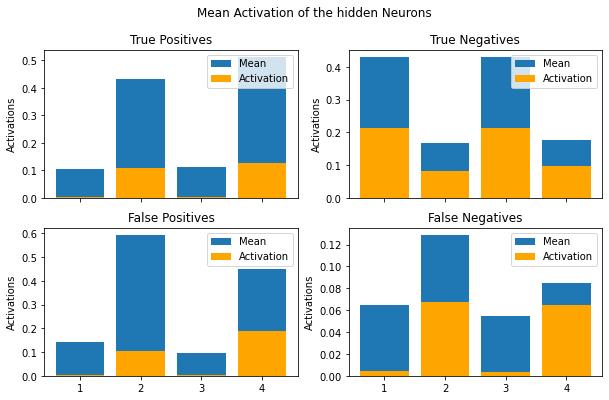

In [88]:
# MEANS

tpa1_mean=np.mean(true_pos_act_1)
tpa2_mean=np.mean(true_pos_act_2)
tpa3_mean=np.mean(true_pos_act_3)
tpa4_mean=np.mean(true_pos_act_4)
tpmeanarr=np.array([tpa1_mean,tpa2_mean,tpa3_mean,tpa4_mean])

tna1_mean=np.mean(true_neg_act_1)
tna2_mean=np.mean(true_neg_act_2)
tna3_mean=np.mean(true_neg_act_3)
tna4_mean=np.mean(true_neg_act_4)
tnmeanarr=np.array([tna1_mean,tna2_mean,tna3_mean,tna4_mean])

fpa1_mean=np.mean(false_pos_act_1)
fpa2_mean=np.mean(false_pos_act_2)
fpa3_mean=np.mean(false_pos_act_3)
fpa4_mean=np.mean(false_pos_act_4)
fpmeanarr=np.array([fpa1_mean,fpa2_mean,fpa3_mean,fpa4_mean])

fna1_mean=np.mean(false_neg_act_1)
fna2_mean=np.mean(false_neg_act_2)
fna3_mean=np.mean(false_neg_act_3)
fna4_mean=np.mean(false_neg_act_4)
fnmeanarr=np.array([fna1_mean,fna2_mean,fna3_mean,fna4_mean])

# VARIANCES

tpa1_v=np.var(true_pos_act_1)
tpa2_v=np.var(true_pos_act_2)
tpa3_v=np.var(true_pos_act_3)
tpa4_v=np.var(true_pos_act_4)
tpvarr=np.array([tpa1_v,tpa2_v,tpa3_v,tpa4_v])

tna1_v=np.var(true_neg_act_1)
tna2_v=np.var(true_neg_act_2)
tna3_v=np.var(true_neg_act_3)
tna4_v=np.var(true_neg_act_4)
tnvarr=np.array([tna1_v,tna2_v,tna3_v,tna4_v])

fpa1_v=np.var(false_pos_act_1)
fpa2_v=np.var(false_pos_act_2)
fpa3_v=np.var(false_pos_act_3)
fpa4_v=np.var(false_pos_act_4)
fpvarr=np.array([fpa1_v,fpa2_v,fpa3_v,fpa4_v])

fna1_v=np.var(false_neg_act_1)
fna2_v=np.var(false_neg_act_2)
fna3_v=np.var(false_neg_act_3)
fna4_v=np.var(false_neg_act_4)
fnvarr=np.array([fna1_v,fna2_v,fna3_v,fna4_v])

# PLOTS

x=np.array([1,2,3,4])

fig, ax = plt.subplots(2,2,figsize=(10,6), sharex=True)

plt.suptitle('Mean Activation of the hidden Neurons')

ax[0][0].bar(x,tpmeanarr)
ax[0][0].bar(x,tpvarr,color='orange')
ax[0][0].set_title('True Positives')
ax[0][0].set_ylabel('Activations')
ax[0][0].legend(['Mean', 'Activation'])
# ax[0][0].set_xlabel('Hidden Layer Neurons')

ax[0][1].bar(x,tnmeanarr)
ax[0][1].bar(x,tnvarr,color='orange')
ax[0][1].set_title('True Negatives')
ax[0][1].set_ylabel('Activations')
ax[0][1].legend(['Mean', 'Activation'])

ax[1][0].bar(x,fpmeanarr)
ax[1][0].bar(x,fpvarr,color='orange')
ax[1][0].set_title('False Positives')
ax[1][0].set_ylabel('Activations')
ax[1][0].legend(['Mean', 'Activation'])

ax[1][1].bar(x,fnmeanarr)
ax[1][1].bar(x,fnvarr,color='orange')
ax[1][1].set_title('False Negatives')
ax[1][1].set_ylabel('Activations')
ax[1][1].legend(['Mean', 'Activation'])


plt.show()

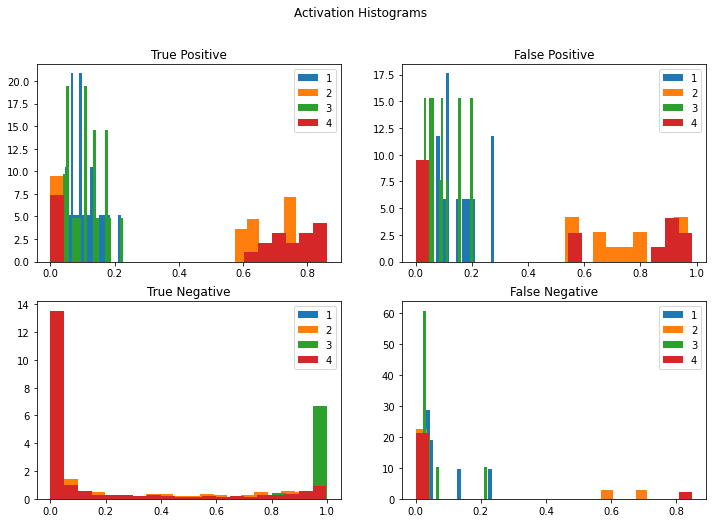

In [87]:
plt.figure(figsize=(12,8))
plt.suptitle('Activation Histograms')
plt.subplot(2,2,1)
plt.hist(true_pos_act_1, bins=20, density=True)
plt.hist(true_pos_act_2, bins=20, density=True)
plt.hist(true_pos_act_3, bins=20, density=True)
plt.hist(true_pos_act_4, bins=20, density=True)
plt.legend(['1','2','3','4'])
plt.title('True Positive')

plt.subplot(2,2,2)
plt.hist(false_pos_act_1, bins=20, density=True)
plt.hist(false_pos_act_2, bins=20, density=True)
plt.hist(false_pos_act_3, bins=20, density=True)
plt.hist(false_pos_act_4, bins=20, density=True)
plt.legend(['1','2','3','4'])
plt.title('False Positive')

plt.subplot(2,2,3)
plt.hist(true_neg_act_1, bins=20, density=True)
plt.hist(true_neg_act_2, bins=20, density=True)
plt.hist(true_neg_act_3, bins=20, density=True)
plt.hist(true_neg_act_4, bins=20, density=True)
plt.legend(['1','2','3','4'])
plt.title('True Negative')

plt.subplot(2,2,4)
plt.hist(false_neg_act_1, bins=20, density=True)
plt.hist(false_neg_act_2, bins=20, density=True)
plt.hist(false_neg_act_3, bins=20, density=True)
plt.hist(false_neg_act_4, bins=20, density=True)
plt.legend(['1','2','3','4'])
plt.title('False Negative');

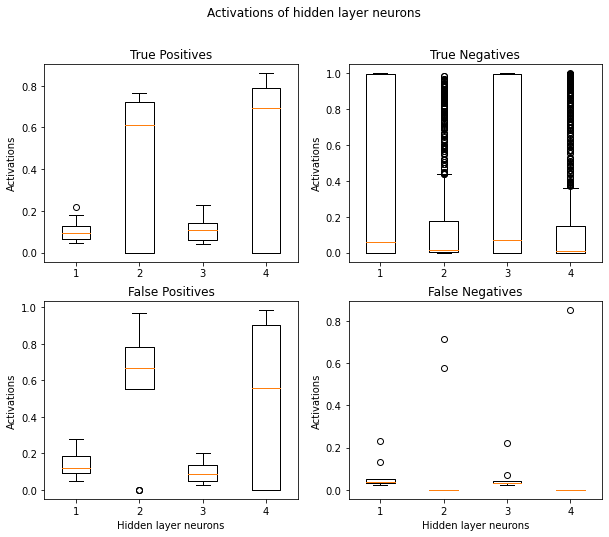

In [96]:
tpdata=[true_pos_act_1,true_pos_act_2,true_pos_act_3,true_pos_act_4]
tndata=[true_neg_act_1,true_neg_act_2,true_neg_act_3,true_neg_act_4]
fpdata=[false_pos_act_1,false_pos_act_2,false_pos_act_3,false_pos_act_4]
fndata=[false_neg_act_1, false_neg_act_2, false_neg_act_3, false_neg_act_4]

plt.figure(figsize=(10,8))
plt.suptitle('Activations of hidden layer neurons')

plt.subplot(2,2,1)
plt.boxplot(tpdata)
plt.title('True Positives')
plt.ylabel('Activations')

plt.subplot(2,2,2)
plt.boxplot(tndata)
plt.title('True Negatives')
plt.ylabel('Activations')

plt.subplot(2,2,3)
plt.boxplot(fpdata)
plt.title('False Positives')
plt.xlabel('Hidden layer neurons')
plt.ylabel('Activations')

plt.subplot(2,2,4)
plt.boxplot(fndata)
plt.title('False Negatives')
plt.xlabel('Hidden layer neurons')
plt.ylabel('Activations');

# 4 Fold Validation

In [6]:
import random

datasetMaker = PalindromeDataset(10)
dataset = datasetMaker.generate_dataset(512, 512)
random.shuffle(dataset)

folds = []
foldsize = len(dataset)//4
for k in range(4):
    folds.append(dataset[k*foldsize:(k+1)*foldsize])

print([f"fold{i} size : {len(f)}" for i, f in enumerate(folds)])



fold_datasets = [(folds[i], [datapoint for fold in [folds[j] for j in range(4) if j != i] for datapoint in fold] ) for i in range(4)]

print([f"fold{i} : {len(f[0])} validation, {len(f[1])} training" for i, f in enumerate(fold_datasets)])

['fold0 size : 256', 'fold1 size : 256', 'fold2 size : 256', 'fold3 size : 256']
['fold0 : 256 validation, 768 training', 'fold1 : 256 validation, 768 training', 'fold2 : 256 validation, 768 training', 'fold3 : 256 validation, 768 training']


For the fold :  0


  0%|          | 0/751 [00:00<?, ?it/s]

epoch 0 loss 532.8638
epoch 50 loss 528.2978
epoch 100 loss 490.8255
epoch 150 loss 462.5216
epoch 200 loss 352.5245
epoch 250 loss 214.5987
epoch 300 loss 123.1447
epoch 350 loss 80.6248
epoch 400 loss 51.7269
epoch 450 loss 41.3854
epoch 500 loss 34.5562
epoch 550 loss 29.4267
epoch 600 loss 24.9933
epoch 650 loss 20.9529
epoch 700 loss 17.7769
epoch 750 loss 15.4527


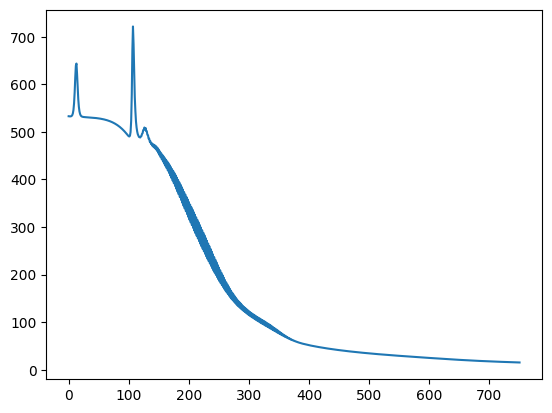

Precision : 0.0000
Accuracy : 0.4883
Recall : 0.0000
F1 Score : 0.0000
[[125   0]
 [131   0]]
For the fold :  1


  0%|          | 0/751 [00:00<?, ?it/s]

epoch 0 loss 538.1221
epoch 50 loss 521.3858
epoch 100 loss 482.6731
epoch 150 loss 354.7740
epoch 200 loss 227.7872
epoch 250 loss 138.9405
epoch 300 loss 94.1299
epoch 350 loss 71.8911
epoch 400 loss 55.5503
epoch 450 loss 41.8774
epoch 500 loss 33.3171
epoch 550 loss 27.9026
epoch 600 loss 23.9421
epoch 650 loss 20.7830
epoch 700 loss 18.1441
epoch 750 loss 15.9254


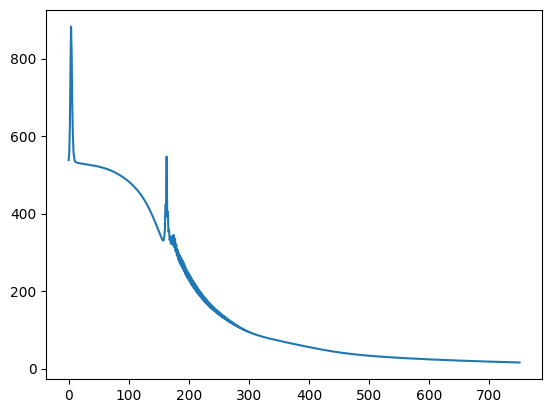

Precision : 1.0000
Accuracy : 0.4883
Recall : 0.0224
F1 Score : 0.0438
[[122   0]
 [131   3]]
For the fold :  2


  0%|          | 0/751 [00:00<?, ?it/s]

epoch 0 loss 545.7278
epoch 50 loss 519.6722
epoch 100 loss 471.2719
epoch 150 loss 371.7882
epoch 200 loss 304.6193
epoch 250 loss 214.7002
epoch 300 loss 165.6486
epoch 350 loss 115.0535
epoch 400 loss 76.1305
epoch 450 loss 58.6578
epoch 500 loss 47.0997
epoch 550 loss 38.6314
epoch 600 loss 32.2085
epoch 650 loss 27.2665
epoch 700 loss 23.4176
epoch 750 loss 20.3786


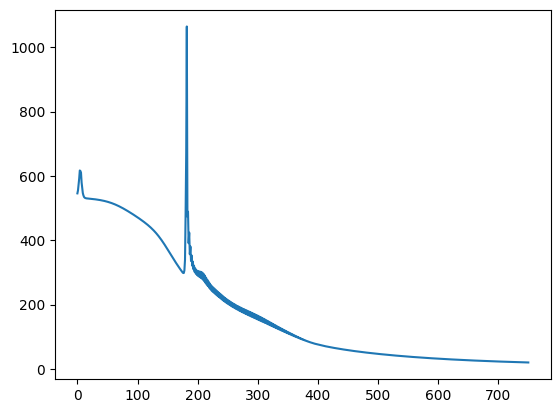

Precision : 0.0000
Accuracy : 0.5195
Recall : 0.0000
F1 Score : 0.0000
[[133   0]
 [123   0]]
For the fold :  3


  0%|          | 0/751 [00:00<?, ?it/s]

epoch 0 loss 541.0860
epoch 50 loss 526.0397
epoch 100 loss 479.5449
epoch 150 loss 445.0539
epoch 200 loss 299.1568
epoch 250 loss 232.2063
epoch 300 loss 187.6741
epoch 350 loss 152.3382
epoch 400 loss 127.0533
epoch 450 loss 114.1587
epoch 500 loss 105.5858
epoch 550 loss 99.0194
epoch 600 loss 93.7503
epoch 650 loss 89.4109
epoch 700 loss 85.7798
epoch 750 loss 79.1268


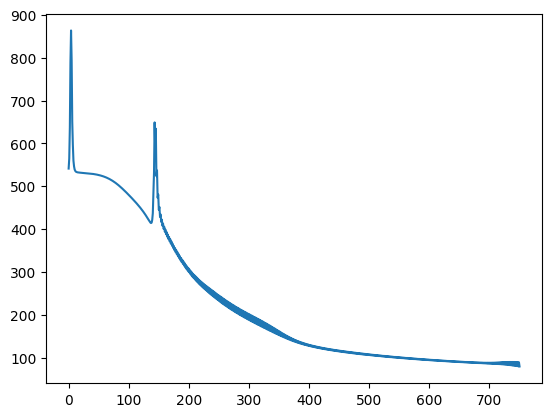

Precision : 0.0000
Accuracy : 0.5078
Recall : 0.0000
F1 Score : 0.0000
[[130   2]
 [124   0]]


In [9]:
from sklearn.metrics import confusion_matrix

for i, fold in enumerate(fold_datasets):

    print("For the fold : ", i)

    losslog = []
    a = MLP(10, [4, 1])
    weight = 1.
    nepochs = 751

    validation, training = fold

    xs, ys = convert_to_form(training)
    xs_val, ys_val = convert_to_form(validation)

    for step in tqdm(range(nepochs)) : 
        # forward pass
        ypred = [a(x)[0] for x in xs]
        # loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
        loss = sum(-weight*ytrue*ypred.log()-(1-ytrue)*(1-ypred).log() for ytrue, ypred in zip(ys, ypred)) # BCE
        losslog.append(loss.data)
        
        a.zero_grad() # taken from Module class
        loss.backward()

        if step%50==0 : tqdm.write(f'epoch {step} loss {loss.data:.4f}')
        
        # update 
        for w in a.parameters() :
            w.data -= 0.005 * w.grad # standard SGD for now
        

    plt.plot(losslog)
    plt.show()

    eps = 1e-8
    predictions = np.array([a(k)[0].data for k in xs_val])
    
    THRESH = 0.99
    preds = 1*(predictions > THRESH)
    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys_val)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys_val)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys_val)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys_val)])

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys_val)

    print(f'Precision : {prec:.4f}')
    print(f'Accuracy : {acc:.4f}')
    print(f"Recall : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    print(confusion_matrix(ys_val, preds))